# <center>  **Classical quantum optimization** <center>

## **Packages**

In [1]:
from variational_algorithms.tensor_networks.tn_algorithms import Pretraining
from variational_algorithms.ansatz import QAOAAnsatz
from variational_algorithms.algorithm import VQE, QAOA
from variational_algorithms.sampler import Sampler
from variational_algorithms.optimizer import CMA_ES
from variational_algorithms.use_cases.maxcut.instances import MaxCut_Instance
from variational_algorithms.use_cases.maxcut.cost_function import MaxCut_CostFunction
from variational_algorithms.use_cases.TSP.cost_function import TSP_CostFunction
from variational_algorithms.use_cases.TSP.instances import TSP_Instance
from variational_algorithms.logger import Logger
from variational_algorithms.tensor_networks.tensor_networks import TensorOperations

from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import numpy as np

# **Max Cut: MPO WI,II for QAOA**

In [2]:
# We define type of problem and size

n_nodes = 10

instance_max_cut = MaxCut_Instance(n_nodes)
instance_max_cut.random_erdos_renyi()

cost_function_max_cut = MaxCut_CostFunction(instance_max_cut)

n_qubits = cost_function_max_cut.num_bin_vars

# We obtain the exact value by brute force
# Warning: Use this method only for small problems

exact_solution = float(instance_max_cut.brute_force()[0][2])

print('Exact solution:', exact_solution)

Exact solution: -18.0


In [3]:
# We initialize the pretraining class with the different parameters

pre = Pretraining(ham = cost_function_max_cut.total_hamiltonian,
                  n_qubits = n_qubits,
                  chi_mpo = 64,
                  fidelity_mps = 1.0,
                  sweeps_mps = 100,
                  init_layers_mps = 1,
                  layers_su4 = 1,
                  connectivity_su4 = 'Linear'
                  )

# We use the temporal evolution method that implements the MPO WI,II algorithm.

pretraining_tevo = pre.time_evolution_pretraining(n_steps = 15,
                                                  dt = 0.01,
                                                  order = 2, 
                                                  init_mps = None,
                                                  metrics = True)

# The result is an object that contains different elements

print(pretraining_tevo)

Results:
effective_dimension: [487.80487804878356]
coherence: [9.237165106675725] 
fun: -13.486109537929329 
fun_history: [-12.118382537323413, -12.23332009582427, -12.34455823429592, -12.452444940600017, -12.557243448049679, -12.659236691911651, -12.758694138153544, -12.855853695859107, -12.950924198237203, -13.044087860858262, -13.135502669566435, -13.225304666178438, -13.313610112007444, -13.400517518146685, -13.486109537929329]
fidelity: 0.9468973308999593
fidelity_history: [0.00022030952919100145, 0.09998492355186675, 0.6377930911485032, 0.7542207317168422, 0.811686558682192, 0.8748469842359244, 0.9204478715844954, 0.9293055365267564, 0.935351203987769, 0.939475531376862, 0.9427482521316531, 0.9446184793746482, 0.9453306797260765, 0.945698395015345, 0.9459268736428574, 0.9461323710245366, 0.9462707982299428, 0.9463897637555806, 0.946496953272784, 0.9465878910715437, 0.9466624563700031, 0.9467211277704513, 0.9467670493631581, 0.9468015588385266, 0.9468269014667055, 0.94684577062759

-0.9799765195126805


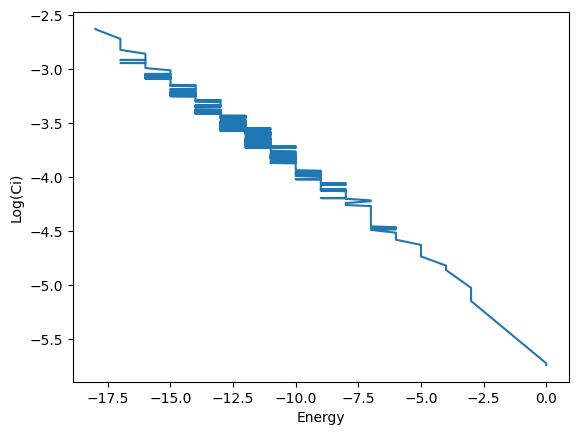

In [4]:
# Only as a validation we check that the final MPS state corresponds to a Gibbs state
# This validation strategy is valid only for small problems.
# For larger problems, the SamplingMPS class can be used to obtain the probability distribution.

probs_list = []
for i in range(2**n_qubits):
    sol_string = bin(i)[2:].zfill(n_qubits)
    prob = abs(TensorOperations(pre.final_mps.tensors).proyection_state(sol_string))**2
    probs_list.append((sol_string, prob))

probs_list = sorted(probs_list, key=lambda tup: tup[1], reverse=True)

energy_x_list = []
pb_log_y_list = []
for i in range(len(probs_list)):
    
    energy_x_list.append(cost_function_max_cut.check_cost_binary(str(probs_list[i][0])))
    pb_log_y_list.append(np.log(np.sqrt(probs_list[i][1])))
    
coefficient_pearson, valor_p = pearsonr(energy_x_list, pb_log_y_list)

print(coefficient_pearson)

plt.plot(energy_x_list, pb_log_y_list)
plt.xlabel('Energy')
plt.ylabel('Log(Ci)')
plt.show()

In [5]:
# We initialize the QAOA algorithm using the circuit obtained from the pretraining class as the initial part of the circuit

optimizer = CMA_ES(max_eval = 1000)
sampler = Sampler()


regular_qaoa_ansatz = QAOAAnsatz(n_qubits=n_qubits, layers=3, costfunction=cost_function_max_cut, ini_circuit = pretraining_tevo.circuit_mps)


qaoa_tsp = QAOA(regular_qaoa_ansatz, cost_function_max_cut, instance_max_cut, optimizer, sampler, n_shots=2000)

# We execute the QAOA algorithm that approximately starts at the end point of the tensor networks optimization
print('Final energy pretraining: ', pretraining_tevo.fun)
print('-----------------------------------------------')

solution2_tsp = qaoa_tsp.solve()

Final energy pretraining:  -13.486109537929329
-----------------------------------------------
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=813839, Wed Nov 27 14:36:14 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 -1.224450000000001e+01 1.0e+00 9.86e-03  9e-03  1e-02 0:00.7
    2     18 -1.232250000000000e+01 1.3e+00 9.92e-03  9e-03  1e-02 0:01.4
    3     27 -1.227300000000001e+01 1.4e+00 9.37e-03  8e-03  1e-02 0:02.2
    7     63 -1.225950000000003e+01 1.8e+00 1.11e-02  1e-02  1e-02 0:05.2
   13    117 -1.262300000000003e+01 2.7e+00 2.00e-02  2e-02  3e-02 0:09.8
   21    189 -1.321300000000003e+01 2.7e+00 7.17e-02  6e-02  7e-02 0:14.9
   32    288 -1.330500000000002e+01 2.7e+00 7.95e-02  5e-02  8e-02 0:21.0
   46    414 -1.347150000000003e+01 3.6e+00 7.79e-02  3e-02  8e-02 0:28.4
   61    549 -1.348650000000000e+01 4.3e+00 4.38e-02  1e-02  4e-02 0:36.4
   80    720 -1.346750000000001e+01 5.9e+00 2.09e-02  6e-03  2e-02 0:45.7
  1

# **TSP Problem: DMRG for QAOA**

In [6]:
# We define type of problem and size

N = 4

instance_tsp = TSP_Instance(N)
instance_tsp.random_uniform_distances()


cost_function_tsp = TSP_CostFunction(instance_tsp, lagrange_multiplier=10)

n_qubits = cost_function_tsp.num_bin_vars


# We obtain the exact value by brute force
# Warning: Use this method only for small problems

exact_solution = instance_tsp.brute_force()[0][1]

print('Exact solution:', exact_solution)

Exact solution: 1.5146345425633134


In [7]:
# We initialize the pretraining class with the different parameters

pre = Pretraining(ham = cost_function_tsp.total_hamiltonian,
                  n_qubits = n_qubits,
                  chi_mpo = 2,
                  fidelity_mps = 1.0,
                  sweeps_mps = 40,
                  init_layers_mps = 1,
                  layers_su4 = 1,
                  connectivity_su4 = 'Linear'
                  )

pretraining_dmrg = pre.dmrg_pretraining(metrics= True, prep_state_dmrg = 'One_state', sweeps_dmrg = 2, lanczos_krydim = 4)

# The result is an object that contains different elements

print(pretraining_dmrg)

Results:
effective_dimension: [1.0]
coherence: [-0.0] 
fun: 2.306602837402181 
fun_history: [129.62597246108697, 119.33684234956922, 113.16558548880137, 98.06893553598891, 87.64619854476209, 82.23699869969103, 81.58279274440201, 71.48614279158438, 66.06340580033537, 65.6542059552752, 61.308411910577064, 55.833367811480855, 55.46691559428923, 50.93383118858674, 40.93383118857477, 40.93383118857352, 40.933831188585486, 40.933831188585515, 40.93383118858422, 40.93383118858429, 40.93383118858446, 33.27258280819194, 33.04811186489033, 31.311474760343117, 22.437262412177006, 21.884358787769003, 21.884358781207254, 14.50132426755411, 2.3069745807540016, 2.306973335774586, 2.306973335745198, 2.306973248772664, 2.306606464795294, 2.3066064647953226, 2.306606464020774, 2.3066064633642895, 2.3066064633520966, 2.30660646319717, 2.306602837411191, 2.3066028374112193, 2.306602837411276, 2.3066028374110203, 2.3066028374105656, 2.306602837411077, 2.306602837410992, 2.306602837410992, 2.306602837411134

In [8]:
# We initialize the QAOA algorithm using the circuit obtained from the pretraining class as the initial part of the circuit

optimizer = CMA_ES(max_eval = 1000)
sampler = Sampler()


regular_qaoa_ansatz = QAOAAnsatz(n_qubits=n_qubits, layers=3, costfunction=cost_function_tsp, ini_circuit = pretraining_dmrg.circuit_mps)


qaoa_tsp = QAOA(regular_qaoa_ansatz, cost_function_tsp, instance_tsp, optimizer, sampler, n_shots=2000)

# We execute the QAOA algorithm that approximately starts at the end point of the tensor networks optimization
print('Final energy pretraining: ', pretraining_dmrg.fun)
print('-----------------------------------------------')

solution2_tsp = qaoa_tsp.solve()

Final energy pretraining:  2.306602837402181
-----------------------------------------------
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=811045, Wed Nov 27 14:37:23 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.222199971741566e+00 1.0e+00 1.04e-02  1e-02  1e-02 0:00.6
    2     18 2.212503086202857e+00 1.4e+00 1.28e-02  1e-02  2e-02 0:01.3
    3     27 2.212503086202857e+00 1.6e+00 1.40e-02  1e-02  2e-02 0:02.0
    8     72 2.212503086202857e+00 2.4e+00 1.34e-02  1e-02  2e-02 0:05.7
   14    126 2.212503086202857e+00 3.7e+00 8.78e-03  6e-03  1e-02 0:10.0
   22    198 2.212503086202857e+00 5.3e+00 5.20e-03  4e-03  5e-03 0:15.1
   26    234 2.212503086202857e+00 5.9e+00 4.10e-03  3e-03  4e-03 0:17.7
termination on tolflatfitness=1 (Wed Nov 27 14:37:41 2024)
final/bestever f-value = 2.212503e+00 2.212503e+00 after 235/11 evaluations
incumbent solution: [-0.021807223650490454, -0.015490393920182744, 0.0020262217347263504, 0.0165738